In [4]:
import sys
sys.path.insert(0, '../../python_dms/lib/')
from tools_dms import *
from dms import *
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.io
import time 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:

np.random.seed(0)

x = np.array(Image.open('../../testset/10081.jpg'))/255.
r,l,_ = np.shape(x)
delta= 0.03
# print(np.random.normal(0,1,x.shape).shape)
z = x+ delta*np.random.normal(0,1,x.shape)



In [7]:

## Without GGS
slpam_at_solver = DMS(
        norm_type="AT",
        edges="similar",
        beta=8,
        lamb=2e-3,
        eps=0.2,
        stop_criterion=1e-4,
        MaximumIteration=500,
        method="SLPAM-eps-descent",
        noised_image_input=z,
        optD="OptD",
        dk_SLPAM_factor=1e-4,
        eps_AT_min=0.02,
        A=np.ones((r,l)))
palm_at_solver = DMS(
        norm_type="AT",
        edges="similar",
        beta=8,
        lamb=7e-2,
        eps=0.2,
        stop_criterion=1e-4,
        MaximumIteration=500,
        method="PALM-eps-descent",
        noised_image_input=z,
        optD="OptD",
        eps_AT_min=0.02,
        A=np.ones((r,l)))



Color image
Image is already in float [0,1] 

Color image
Image is already in float [0,1] 



In [8]:
time1 = time.time()
out_slpam_at = slpam_at_solver.process()
time_slpam_at = time.time()-time1

0.2
0.13333333333333333
0.08888888888888889
0.05925925925925926
0.03950617283950617
0.02633744855967078


In [9]:
time2 = time.time()
out_palm_at = palm_at_solver.process()
time_palm_at= time.time()-time2

Epsilon:  0.2
Epsilon:  0.13333333333333333
Epsilon:  0.08888888888888889
Epsilon:  0.05925925925925926
Epsilon:  0.03950617283950617
Epsilon:  0.02633744855967078


In [10]:
print("SLPAM-CT:",time_slpam_at)
print("PALM-CT:",time_palm_at)

SLPAM-CT: 1036.052775144577
PALM-CT: 1134.3261919021606


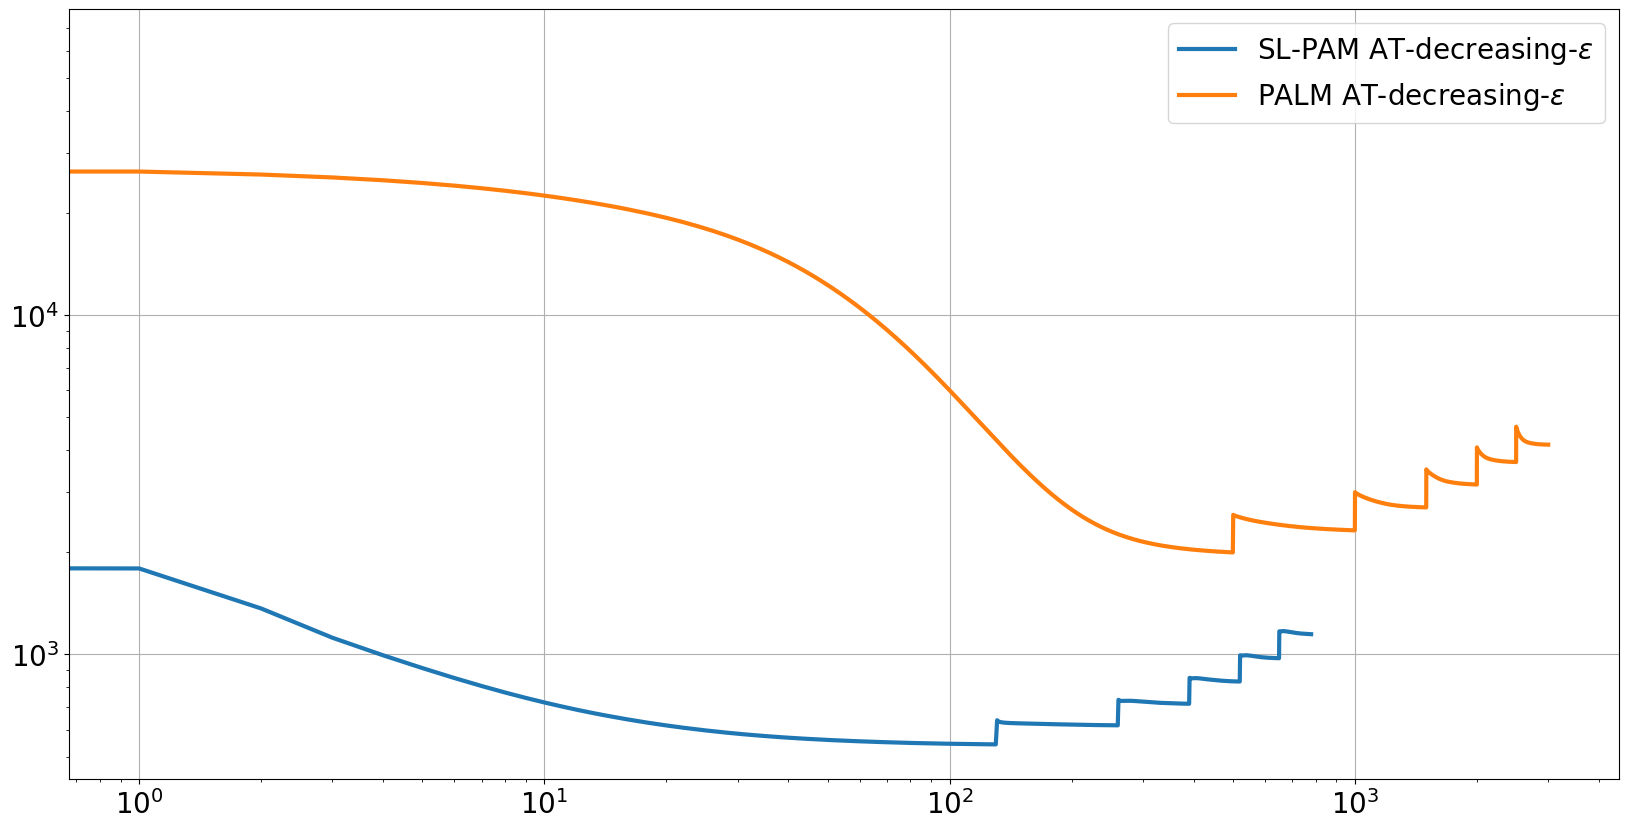

In [11]:
plt.figure(figsize=(20,10))
plt.loglog(out_slpam_at[2], linewidth=3,label='SL-PAM AT-decreasing-$\epsilon$')
plt.loglog(out_palm_at[2], linewidth=3,label='PALM AT-decreasing-$\epsilon$')
plt.legend(fontsize=20)
plt.grid('on')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('crit_dms_at_compare_decreasing_eps.png', bbox_inches='tight', pad_inches=0)


In [12]:
plt.figure(figsize=(20,10))
e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
x1 = out_slpam_at[3][0]
x=np.copy(x1)
for i in range(rows):
    # Loop through each column
    for j in range(cols):
        # If the column index is greater than the row index, it's an element in the upper diagonal
        if j > i*(481/321):
            x[i,j,0]=1-e1[i,j]
            x[i,j,1]=1-e1[i,j]
            x[i,j,2]=1-e1[i,j]
plt.imshow(x)
plt.axis('off')
plt.savefig('x_est_eps_0.png', bbox_inches='tight', pad_inches=0)
plt.show()


NameError: name 'rows' is not defined

<Figure size 2000x1000 with 0 Axes>

In [ ]:

plt.figure(figsize=(20,10))
plt.imshow(x)
plt.axis('off')
plt.savefig('x.png', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(z)
plt.axis('off')
plt.savefig('z.png', bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:

plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[1])
plt.axis('off')
plt.savefig('x_est_at_decreasing.png', bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:

plt.figure(figsize=(20,10))
plt.imshow(x[200:400,200:400,:])
plt.axis('off')
plt.savefig('zoom_x.png', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(z[200:400,200:400,:])
plt.axis('off')
plt.savefig('zoom_z.png', bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1],cmap='gray_r')
plt.axis('off')
plt.savefig('e_eps_0.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][1][:,:,0]+out_slpam_at[4][1][:,:,1],cmap='gray_r')
plt.axis('off')
plt.savefig('e_eps_1.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][2][:,:,0]+out_slpam_at[4][2][:,:,1],cmap='gray_r')
plt.axis('off')
plt.savefig('e_eps_2.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][3][:,:,0]+out_slpam_at[4][3][:,:,1],cmap='gray_r')
plt.axis('off')
plt.savefig('e_eps_3.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][4][:,:,0]+out_slpam_at[4][4][:,:,1],cmap='gray_r')
plt.axis('off')
plt.savefig('e_eps_4.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][5][:,:,0]+out_slpam_at[4][5][:,:,1],cmap='gray_r')
plt.axis('off')
plt.savefig('e_eps_5.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
rows, cols = 321,481

In [ ]:
plt.figure(figsize=(20,10))
e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
x1 = out_slpam_at[3][0]
x=np.copy(x1)
for i in range(rows):
    # Loop through each column
    for j in range(cols):
        # If the column index is greater than the row index, it's an element in the upper diagonal
        if j > i*(481/321):
            x[i,j,0]=1-e1[i,j]/2
            x[i,j,1]=1-e1[i,j]/2
            x[i,j,2]=1-e1[i,j]/2
plt.imshow(x)
plt.axis('off')
plt.savefig('x_est_eps_0.png', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(20,10))
e1 = out_slpam_at[4][1][:,:,0]+out_slpam_at[4][1][:,:,1]
x1 = out_slpam_at[3][1]
x=np.copy(x1)
for i in range(rows):
    # Loop through each column
    for j in range(cols):
        # If the column index is greater than the row index, it's an element in the upper diagonal
        if j > i*(481/321):
            x[i,j,0]=1-e1[i,j]/2
            x[i,j,1]=1-e1[i,j]/2
            x[i,j,2]=1-e1[i,j]/2
plt.imshow(x)
plt.axis('off')
plt.savefig('x_est_eps_1.png', bbox_inches='tight', pad_inches=0)
plt.show()


plt.figure(figsize=(20,10))
plt.hist(e1.flatten())
plt.grid('on')
plt.show()

plt.figure(figsize=(20,10))
e1 = out_slpam_at[4][2][:,:,0]+out_slpam_at[4][2][:,:,1]
x1 = out_slpam_at[3][2]
x=np.copy(x1)
for i in range(rows):
    # Loop through each column
    for j in range(cols):
        # If the column index is greater than the row index, it's an element in the upper diagonal
        if j > i*(481/321):
            x[i,j,0]=1-e1[i,j]/2
            x[i,j,1]=1-e1[i,j]/2
            x[i,j,2]=1-e1[i,j]/2
plt.imshow(x)
plt.axis('off')
plt.savefig('x_est_eps_2.png', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(20,10))
e1 = out_slpam_at[4][3][:,:,0]+out_slpam_at[4][3][:,:,1]
x1 = out_slpam_at[3][3]
x=np.copy(x1)
for i in range(rows):
    # Loop through each column
    for j in range(cols):
        # If the column index is greater than the row index, it's an element in the upper diagonal
        if j > i*(481/321):
            x[i,j,0]=1-e1[i,j]/2
            x[i,j,1]=1-e1[i,j]/2
            x[i,j,2]=1-e1[i,j]/2
plt.imshow(x)
plt.axis('off')
plt.savefig('x_est_eps_3.png', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(20,10))
e1 = out_slpam_at[4][4][:,:,0]+out_slpam_at[4][4][:,:,1]
x1 = out_slpam_at[3][4]
x=np.copy(x1)
for i in range(rows):
    # Loop through each column
    for j in range(cols):
        # If the column index is greater than the row index, it's an element in the upper diagonal
        if j > i*(481/321):
            x[i,j,0]=1-e1[i,j]/2
            x[i,j,1]=1-e1[i,j]/2
            x[i,j,2]=1-e1[i,j]/2
plt.imshow(x)
plt.axis('off')
plt.savefig('x_est_eps_4.png', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(20,10))
e1 = out_slpam_at[4][5][:,:,0]+out_slpam_at[4][5][:,:,1]
x1 = out_slpam_at[3][5]
x=np.copy(x1)
for i in range(rows):
    # Loop through each column
    for j in range(cols):
        # If the column index is greater than the row index, it's an element in the upper diagonal
        if j > i*(481/321):
            x[i,j,0]=1-e1[i,j]/2
            x[i,j,1]=1-e1[i,j]/2
            x[i,j,2]=1-e1[i,j]/2
plt.imshow(x)
plt.axis('off')
plt.savefig('x_est_eps_5.png', bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
bins = np.linspace(0, 1, 20)
plt.figure(figsize=(5,5))
# e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
# plt.hist(e1.flatten()/2)
plt.hist(out_slpam_at[4][0][:,:,0].flatten(),bins,alpha=0.3,color='blue')
plt.hist(out_slpam_at[4][0][:,:,1].flatten(),bins,alpha=0.3,color='green')
plt.savefig('hist_est_eps_0.png', bbox_inches='tight', pad_inches=0)
plt.ylim(0,120000)
plt.show()

plt.figure(figsize=(5,5))
# e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
# plt.hist(e1.flatten()/2)
plt.hist(out_slpam_at[4][1][:,:,0].flatten(),bins,alpha=0.3,color='blue')
plt.hist(out_slpam_at[4][1][:,:,1].flatten(),bins,alpha=0.3,color='green')
plt.savefig('hist_est_eps_1.png', bbox_inches='tight', pad_inches=0)
plt.ylim(0,120000)
plt.show()

plt.figure(figsize=(5,5))
# e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
# plt.hist(e1.flatten()/2)
plt.hist(out_slpam_at[4][2][:,:,0].flatten(),bins,alpha=0.3,color='blue')
plt.hist(out_slpam_at[4][2][:,:,1].flatten(),bins,alpha=0.3,color='green')
plt.savefig('hist_est_eps_2.png', bbox_inches='tight', pad_inches=0)
plt.ylim(0,120000)
plt.show()

plt.figure(figsize=(5,5))
# e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
# plt.hist(e1.flatten()/2)
plt.hist(out_slpam_at[4][3][:,:,0].flatten(),bins,alpha=0.3,color='blue')
plt.hist(out_slpam_at[4][3][:,:,1].flatten(),bins,alpha=0.3,color='green')
plt.savefig('hist_est_eps_3.png', bbox_inches='tight', pad_inches=0)
plt.ylim(0,120000)
plt.show()

plt.figure(figsize=(5,5))
# e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
# plt.hist(e1.flatten()/2)
plt.hist(out_slpam_at[4][4][:,:,0].flatten(),bins,alpha=0.3,color='blue')
plt.hist(out_slpam_at[4][4][:,:,1].flatten(),bins,alpha=0.3,color='green')
plt.savefig('hist_est_eps_4.png', bbox_inches='tight', pad_inches=0)
plt.ylim(0,120000)
plt.show()

plt.figure(figsize=(5,5))
# e1 = out_slpam_at[4][0][:,:,0]+out_slpam_at[4][0][:,:,1]
# plt.hist(e1.flatten()/2)
plt.hist(out_slpam_at[4][5][:,:,0].flatten(),bins,alpha=0.3,color='blue')
plt.hist(out_slpam_at[4][5][:,:,1].flatten(),bins,alpha=0.3,color='green')
plt.savefig('hist_est_eps_5.png', bbox_inches='tight', pad_inches=0)
plt.ylim(0,120000)
plt.show()


In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[3][0][200:400,200:400,:])
plt.axis('off')
plt.savefig('zoom_x_est_eps_0.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[3][1][200:400,200:400,:])
plt.axis('off')
plt.savefig('zoom_x_est_eps_1.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[3][2][200:400,200:400,:])
plt.axis('off')
plt.savefig('zoom_x_est_eps_2.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[3][3][200:400,200:400,:])
plt.axis('off')
plt.savefig('zoom_x_est_eps_3.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[3][4][200:400,200:400,:])
plt.axis('off')
plt.savefig('zoom_x_est_eps_4.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[3][5][200:400,200:400,:])
plt.axis('off')
plt.savefig('zoom_x_est_eps_5.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][0][200:400,200:400,0]+out_slpam_at[4][0][200:400,200:400,1],cmap='gray_r')
plt.axis('off')
plt.savefig('zoom_e_eps_0.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][1][200:400,200:400,0]+out_slpam_at[4][1][200:400,200:400,1],cmap='gray_r')
plt.axis('off')
plt.savefig('zoom_e_eps_1.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][2][200:400,200:400,0]+out_slpam_at[4][2][200:400,200:400,1],cmap='gray_r')
plt.axis('off')
plt.savefig('zoom_e_eps_2.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][3][200:400,200:400,0]+out_slpam_at[4][3][200:400,200:400,1],cmap='gray_r')
plt.axis('off')
plt.savefig('zoom_e_eps_3.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][4][200:400,200:400,0]+out_slpam_at[4][4][200:400,200:400,1],cmap='gray_r')
plt.axis('off')
plt.savefig('zoom_e_eps_4.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(out_slpam_at[4][5][200:400,200:400,0]+out_slpam_at[4][5][200:400,200:400,1],cmap='gray_r')
plt.axis('off')
plt.savefig('zoom_e_eps_5.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
np.shape(out_slpam_at[4][0])